Dual Encoder-Decoder archetecture 

In [3]:
import torch
import torchvision
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoder, self).__init__()
        self.resnet = nn.Sequential(*list(torchvision.models.resnet50(pretrained=True).children())[:-1])
        self.linear = nn.Linear(2048, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        out_linear = self.linear(features)
        embeddings = self.bn(out_linear)
        return embeddings


class SemanticEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(SemanticEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)

    def forward(self, texts):
        embeddings = self.embedding(texts)
        hiddens, _ = self.lstm(embeddings)

        return hiddens[:, -1]


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=embed_size + hidden_size, hidden_size=hidden_size)
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=hidden_size, out_features=vocab_size)
        # embedding layer
        self.embed = nn.Embedding(num_embeddings=vocab_size + hidden_size, embedding_dim=embed_size + hidden_size)
        # activations
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, captions):
        # batch size
        batch_size = features.size(0)
        # init the hidden and cell states to zeros
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        # define the output tensor placeholder
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(device)
        # embed the captions
        captions_embed = self.embed(captions)
        # pass the caption word by word
        for t in range(captions.size(1)):
            # for the first time step the input is the feature vector
            if t == 0:
                hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
            # for the 2nd+ time step, using teacher forcer
            else:
                hidden_state, cell_state = self.lstm_cell(captions_embed[:, t, :], (hidden_state, cell_state))
            # output of the attention mechanism
            out = self.fc_out(hidden_state)
            # build the output tensor
            outputs[:, t, :] = out
        return outputs

    def sample(self, features, max_seg_length):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        # inputs = features.unsqueeze(1)
        batch_size = features.size(0)
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        for i in range(max_seg_length):
            # hiddens, states = self.lstm(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
            # outputs = self.linear(hiddens.squeeze(1))  # outputs:  (batch_size, vocab_size)
            outputs = self.fc_out(hidden_state)
            _, predicted = outputs.max(1)  # predicted: (batch_size)
            sampled_ids.append(predicted)
            features = self.embed(predicted)  # inputs: (batch_size, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)  # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [4]:
import pickle
from ipynb.fs.full.data_loader import ROCODataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format('png')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embed_size=256
hidden_size=512
num_layers=1
learning_rate=0.001
num_epochs=3
batch_size=32
vocab_path='vocab.pkl'
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
vocab_size = len(vocab) + 1
      
image_encoder = ImageEncoder(embed_size).to(device)
semantic_encoder = SemanticEncoder(vocab_size, embed_size, hidden_size, num_layers).to(device)
decoder = Decoder(vocab_size, embed_size, hidden_size).to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ROCODataset(data_json='selected_dataset-60000/selected_dataset_60000_info.json',
                            transform=transform,
                            vocab=vocab,
                            dataset_type='train')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
                            collate_fn=ROCODataset.collate_fn,
                            num_workers=2)
images, captions, lengths = None, None, None
for i, (images, captions, lengths) in enumerate(train_loader):
    images = images
    captions = captions
    lengths = lengths
    break

images = images.to(device)
captions_target = captions.to(device)
captions_train = captions[:, :captions.shape[1] - 1].to(device)
image_features = image_encoder(images)

# model_graph_0 = draw_graph(torchvision.models.resnet18(), input_size=(1,3,32,32))
# model_graph_0 = draw_graph(nn.Sequential(*list(torchvision.models.resnet50(pretrained=True).children())[:-1]), input_size=images.size())
image_encoder_graph = draw_graph(image_encoder, input_size=images.size(), graph_name='ImageEncoder', roll=True, depth=1)

text_features = semantic_encoder(captions_train)

semantic_encoder_model_graph = draw_graph(
    semantic_encoder, captions_train,
    graph_name='SemanticEncoder',
    roll=True
)

combined_features = torch.cat((image_features, text_features), dim=1)
outputs = decoder(combined_features, captions_target)
decoder_model_graph = draw_graph(
    decoder, (combined_features, captions_target),
    graph_name='Decoder',
    roll=True
)


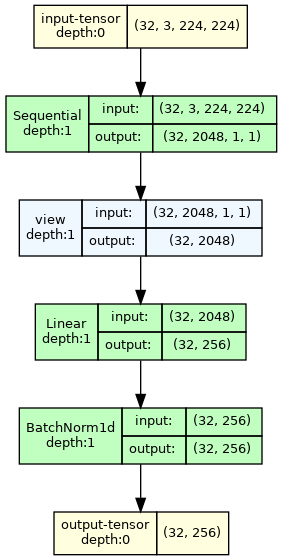

In [5]:
image_encoder_graph.visual_graph

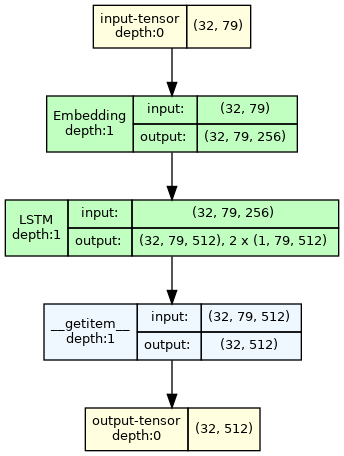

In [6]:
semantic_encoder_model_graph.visual_graph

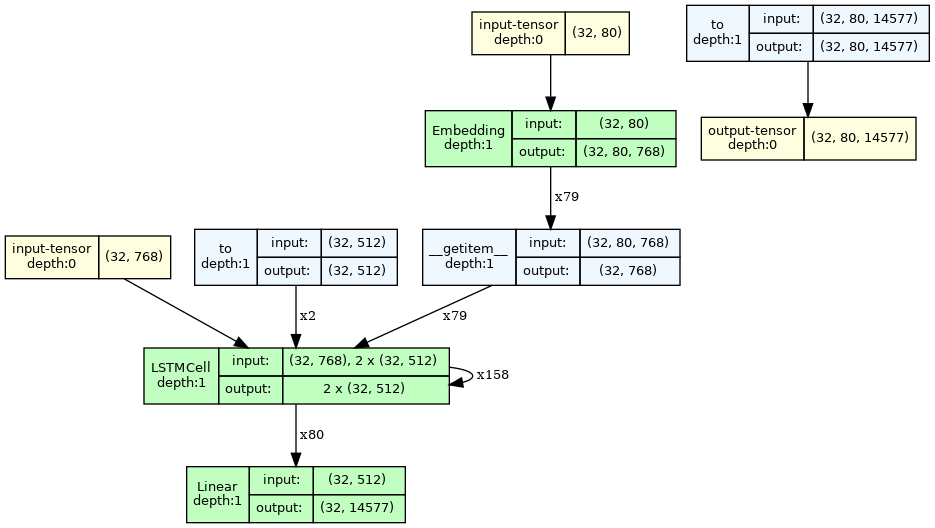

In [7]:
decoder_model_graph.visual_graph

Single Encoder-Decoder archetecture 

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20, pretrained=None):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True) # change for LSTM or RNN
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        self.pretrained = pretrained
        if self.pretrained:
            print(f'loading pretrained model: {pretrained}')
            weight = torch.load(self.pretrained)
            weight = weight.to(device)
            self.prembed = nn.Embedding.from_pretrained(weight, freeze=True)

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        if self.pretrained:
            embeddings = self.prembed(captions).float()
        else:
            embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, pretrained=None, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            if pretrained:
                inputs = self.prembed(predicted).float()
            else:
                inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [11]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)


encoder_model_graph = draw_graph(
    encoder, images,
    graph_name='Encoder',
    roll=True,
    depth =1
)
features = encoder(images)
decoder_model_graph = draw_graph(
    decoder, (features, captions, lengths),
    graph_name='Decoder',
    roll=True
)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


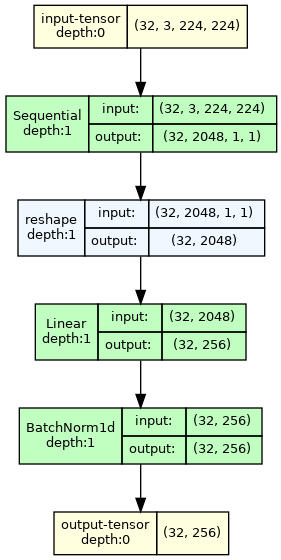

In [12]:
encoder_model_graph.visual_graph

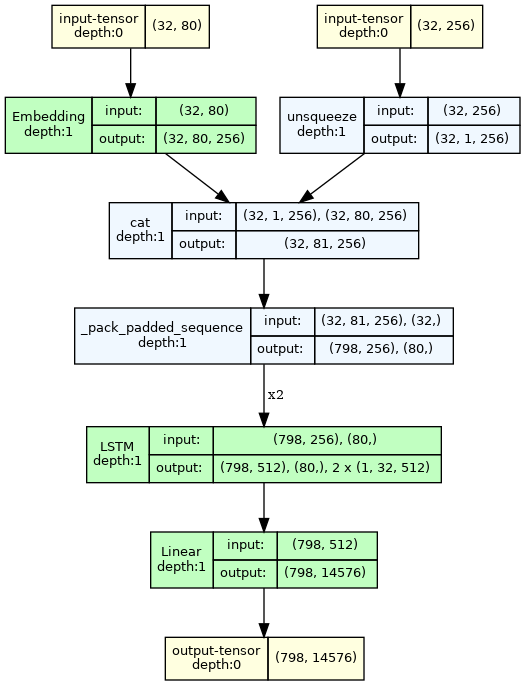

In [13]:
decoder_model_graph.visual_graph